In [1]:
import matplotlib.pyplot as plt
from models import VAE_CNN

import seaborn as sns
import numpy as np
import torch
import os
from skimage import io, transform
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from skimage.io import imread
from torchsummary import summary
import pandas as pd
import time

TRAIN_ROOT = 'data-portinari/Train/'
VAL_ROOT = 'data-portinari/Validation/'

TRAIN_ROOT_FIX = 'data-portinari/Fix_sample_train/'
VAL_ROOT_FIX = 'data-portinari/Fix_sample_validation/'


BATCH_SIZE = 32
EPOCHS = 10
LOG_INTERVAL = 50
BOTTLENECK_SIZE = 512

In [2]:
no_cuda = False
seed = 1
cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
torch.manual_seed(seed)

transform_seq = [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]

train_loader_celeba = torch.utils.data.DataLoader(
    datasets.ImageFolder(TRAIN_ROOT, transform=transforms.Compose(transform_seq)),
    drop_last = False, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

val_loader_celeba = torch.utils.data.DataLoader(
    datasets.ImageFolder(VAL_ROOT, transform=transforms.Compose(transform_seq)), 
    drop_last = False, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

train_loader_celeba_fix = torch.utils.data.DataLoader(
    datasets.ImageFolder(TRAIN_ROOT_FIX, transform=transforms.Compose(transform_seq)),
    drop_last = False, batch_size = 10, shuffle=False, **kwargs)

val_loader_celeba_fix = torch.utils.data.DataLoader(
    datasets.ImageFolder(VAL_ROOT_FIX, transform=transforms.Compose(transform_seq)), 
    drop_last = False, batch_size = 10, shuffle=False, **kwargs)

In [3]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="mean")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE, 0.000001 * loss_KLD

In [4]:
model = VAE_CNN(BOTTLENECK_SIZE).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha= 0.9)
loss_custom = customLoss()

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline
def show(img):
    npimg = img.detach().numpy()
    plt.figure(figsize=(30, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [6]:
checkpoint = torch.load('model_KL_10e-5')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



<All keys matched successfully>

In [7]:
enc_layers = ['conv1', 'conv2', 'conv3', 'conv4']
dec_layers = ['conv5', 'conv6', 'conv7', 'conv8', 'conv9']

tests = [['0000','0000'], 
         ['0006','2132'], ['0006','2432'], ['0006','2732'], ['0006','0000'],
         ['0009','2132'], ['0009','2432'], ['0009','2732'], ['0009','0000']]


In [28]:
'''layers = []
for ly in model.named_children():
    layers.append(ly)
i = 0 
for ly in layers:
    #print(i, ly)
    i = i +1
    
parameters= []

for i in [0, 6,9, 12, 19, 25]:
    parameters.append((i, layers[i][1].bias.cpu().detach().numpy()))'''

'layers = []\nfor ly in model.named_children():\n    layers.append(ly)\ni = 0 \nfor ly in layers:\n    #print(i, ly)\n    i = i +1\n    \nparameters= []\n\nfor i in [0, 6,9, 12, 19, 25]:\n    parameters.append((i, layers[i][1].bias.cpu().detach().numpy()))'

In [12]:

LYR_ENC = '0009'
LYR_DEC = '2432'


LYR_ENC_START = int(str(LYR_ENC[0])+str(LYR_ENC[1]))
LYR_ENC_END = int(LYR_ENC[2]+LYR_ENC[3])
LYR_DEC_START = int(LYR_DEC[0]+LYR_DEC[1])
LYR_DEC_END = int(LYR_DEC[2]+LYR_DEC[3])


for i in range(0, 32):
    layers[i][1].requires_grad_(True)

print("Frozen layers - encoder:\n")
for i in range(LYR_ENC_START, LYR_ENC_END):
    layers[i][1].requires_grad_(False)
    print(i, layers[i][1])
print("\nFrozen layers - decoder:\n")
for i in range(LYR_DEC_START, LYR_DEC_END):
    layers[i][1].requires_grad_(False)
    print(i, layers[i][1])

Frozen layers - encoder:

0 Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
6 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
8 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

Frozen layers - decoder:

24 Upsample(scale_factor=2.0, mode=nearest)
25 ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
26 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
27 Upsample(scale_factor=2.0, mode=nearest)
28 ConvTranspos

In [13]:
'''layers = []

for child in model.named_children():
    child[1].requires_grad_(True)
    print(child)
    for name, par in child[1].named_parameters():
        print(name)
    
model.conv3.bias'''

'layers = []\n\nfor child in model.named_children():\n    child[1].requires_grad_(True)\n    print(child)\n    for name, par in child[1].named_parameters():\n        print(name)\n    \nmodel.conv3.bias'

In [14]:
val_losses = []
train_losses = []

def train(epoch):
    epoch_start = 0
    model.train()
    train_loss = 0
    start = time.time()
    for batch_idx, (data, _) in enumerate(train_loader_celeba): 
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
        loss = loss_mse + loss_kl
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            interval = time.time() - start
            start = time.time()
            epoch_start = epoch_start + interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss MSE: {:.6f} \tLoss KL: {:.6f} \tTime Interv: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_celeba.dataset),
                       100. * batch_idx / len(train_loader_celeba),
                       loss_mse.item() / len(data), loss_kl.item() / len(data), interval))
        '''    
        if batch_idx == 0:
            n = 8
            comparison = torch.cat([data[:n],
                                    recon_batch[:n].view(8, 3, 200, 200)])
            show(make_grid(comparison.cpu(), nrow=n, normalize=True))'''

    print('====> Epoch: {} Average loss: {:.4f} Elapsed Time: {:.6f}'.format(
        epoch, train_loss / len(train_loader_celeba.dataset), epoch_start))
    train_losses.append(train_loss / len(train_loader_celeba.dataset))


In [15]:
def test(epoch, sufix, train):
    model.train(train)
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader_celeba):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
            loss = loss_mse + loss_kl
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(BATCH_SIZE, 3, 200, 200)[:n]])
                save_image(comparison.cpu(),
                           'results-portinari/reconstruction_' + str(epoch) + sufix + '.png', nrow=n, normalize=True)

    test_loss /= len(val_loader_celeba.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [16]:
def reconstruction_hist(loader, epoch, imgs_conc):
    
    model.train(True)
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            
            if epoch == 1:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                n = min(data.size(0), 7)
                print('entrou1')
                imgs_conc = torch.cat([data[:n],
                                        recon_batch.view(7, 3, 200, 200)[:n]])
                
            elif (epoch % 4) == 1: 
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                print('entrou')
                n = min(data.size(0), 7)
                imgs_conc = torch.cat([imgs_conc,
                                        recon_batch.view(7, 3, 200, 200)[:n]])
            #show(make_grid(comparison.cpu(), nrow=n, normalize=True))
    return imgs_conc

In [17]:
600000/(200*200*3)

5.0

In [18]:
imgs = []

for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch, '_on', True)
    test(epoch, '_off', False)
    imgs = reconstruction_hist(train_loader_celeba_fix, epoch, imgs)
    with torch.no_grad():
        sample = torch.randn(BATCH_SIZE, BOTTLENECK_SIZE).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(BATCH_SIZE, 3, 200, 200),
                   'results-portinari/sample_' + str(epoch) + '.png', normalize=True)

Train Epoch: 1 [0/305 (0%)]	Loss MSE: 0.024723 	Loss KL: 0.000309 	Time Interv: 0.942063
Train Epoch: 1 [250/305 (82%)]	Loss MSE: 0.015073 	Loss KL: 0.000311 	Time Interv: 1.943425
====> Epoch: 1 Average loss: 0.0213 Elapsed Time: 2.885488
====> Test set loss: 0.0222
====> Test set loss: 0.1015
entrou1
Train Epoch: 2 [0/305 (0%)]	Loss MSE: 0.023132 	Loss KL: 0.000312 	Time Interv: 0.094265
Train Epoch: 2 [250/305 (82%)]	Loss MSE: 0.027013 	Loss KL: 0.000314 	Time Interv: 2.030820
====> Epoch: 2 Average loss: 0.0171 Elapsed Time: 2.125085
====> Test set loss: 0.0187
====> Test set loss: 0.1073
Train Epoch: 3 [0/305 (0%)]	Loss MSE: 0.014610 	Loss KL: 0.000315 	Time Interv: 0.081730
Train Epoch: 3 [250/305 (82%)]	Loss MSE: 0.015692 	Loss KL: 0.000317 	Time Interv: 2.063380
====> Epoch: 3 Average loss: 0.0139 Elapsed Time: 2.145110
====> Test set loss: 0.0156
====> Test set loss: 0.1023
Train Epoch: 4 [0/305 (0%)]	Loss MSE: 0.014405 	Loss KL: 0.000318 	Time Interv: 0.109742
Train Epoch: 4 

KeyboardInterrupt: 

In [26]:
'''layers_after = []
for ly in model.named_children():
    layers_after.append(ly)
i = 0 
for ly in layers_after:
    print(i, ly)
    i = i +1


parameters_after= []

for i in [0, 6,9, 12, 19, 25]:
    parameters_after.append((i, layers_after[i][1].bias.cpu().detach().numpy()))'''

'layers_after = []\nfor ly in model.named_children():\n    layers_after.append(ly)\ni = 0 \nfor ly in layers_after:\n    print(i, ly)\n    i = i +1\n\n\nparameters_after= []\n\nfor i in [0, 6,9, 12, 19, 25]:\n    parameters_after.append((i, layers_after[i][1].bias.cpu().detach().numpy()))'

In [27]:
#parameters[5][1] - parameters_after[5][1]

In [24]:
imgs

'''torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "model_KL_10e-5")'''

'torch.save({\n            \'model_state_dict\': model.state_dict(),\n            \'optimizer_state_dict\': optimizer.state_dict(),\n            }, "model_KL_10e-5")'

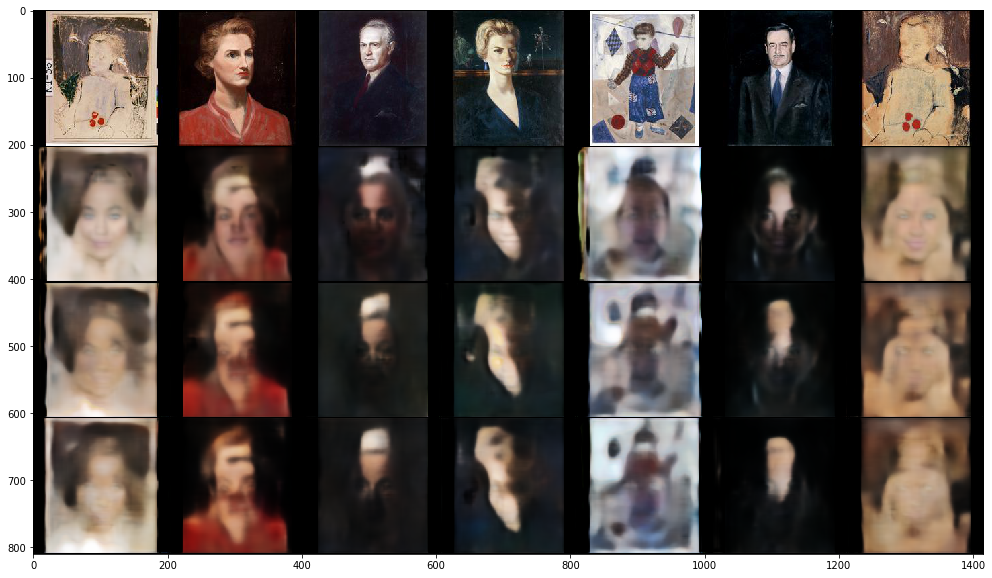

In [25]:
show(make_grid(imgs.cpu(), nrow=7, normalize=True))

In [45]:
show(make_grid(imgs.cpu(), nrow=7, normalize=True))

AttributeError: 'list' object has no attribute 'cpu'

In [24]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [22]:
data = 1
recon_batch = 1
logvar = 1
mu = 1
loss_mse = 1
loss_kl = 1
loss = 1
test_loss = 1
comparison = 1 
torch.cuda.empty_cache()


In [24]:

model.train(True)
test_loss = 0
for i, (data, _) in enumerate(train_loader_celeba):
    print('hi')
    data = data.to(device)
    recon_batch, mu, logvar = model(data)
    loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
    loss = loss_mse + loss_kl
    test_loss += loss.item()
    if i == 0:
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                                recon_batch.view(32, 3, 200, 200)[:n]])
        show(make_grid(comparison.cpu(), nrow=n, normalize=True)) 

hi


RuntimeError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 7.93 GiB total capacity; 7.14 GiB already allocated; 81.25 MiB free; 133.96 MiB cached)

In [ ]:
checkpoint = torch.load('model_save')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']



In [ ]:
loss

In [21]:
model.train(True)
test_loss = 0
for i, (data, _) in enumerate(val_loader_celeba):
    data = data.to(device)
    recon_batch, mu, logvar = model(data)
    loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
    loss = loss_mse + loss_kl
    test_loss += loss.item()
    if i == 0:
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                                recon_batch.view(8, 3, 200, 200)[:n]])
        show(make_grid(comparison.cpu(), nrow=n, normalize=True))

RuntimeError: shape '[8, 3, 200, 200]' is invalid for input of size 3840000

AttributeError: 'int' object has no attribute 'cpu'

<Figure size 2160x720 with 0 Axes>

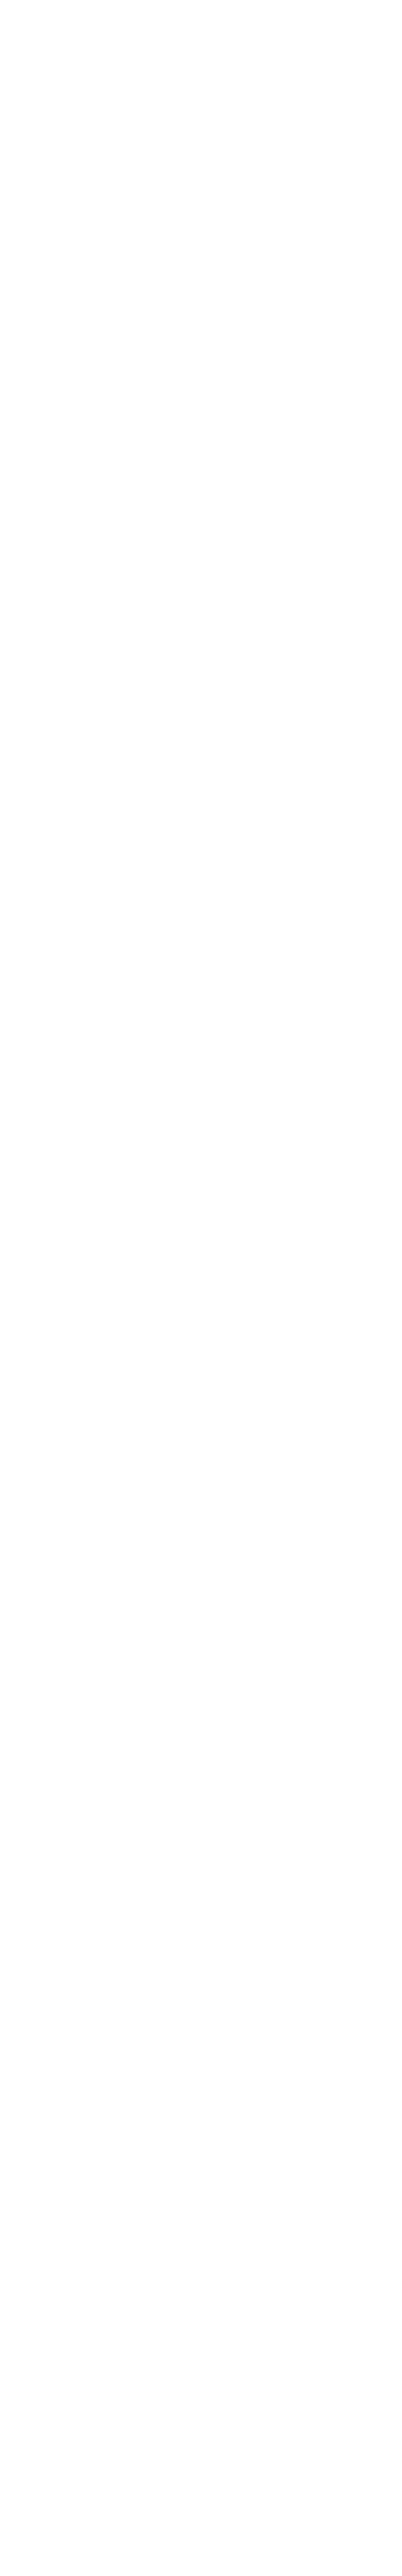

In [20]:
import random
x_test = []
plt.figure(figsize=(30,10))
num_figs = 1
plt.figure(figsize=(15,100))
plt.axis('off')
plt.imshow(make_grid(comparison.cpu(), nrow=n, normalize=True).detach().numpy())
'''
for i in range(num_figs):
    figure_Decoded = vae_2.predict(np.array([x_test[i].astype('float32')/127.5 -1]), batch_size = b_size)
    plt.axis('off')
    plt.subplot(num_figs,2,1+i*2)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(num_figs,2,2 + i*2)
    plt.imshow((figure_Decoded[0]+1)/2)
    plt.axis('off')
'''
plt.show()

In [ ]:
torch.save({
            'epoch': 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "model_save")